## Pretrained models

### Torchvision

[torchvision](https://github.com/pytorch/vision) - библиотека, содержащая популярные CV датасеты, утилиты для препроцессинга и, самое важное, pre-trained модели для классификации, обученные на [ImageNet](http://image-net.org/).

Большая часть потребностей покрывается имеющимися моделями, но если нужна какая-то другая архитектура или нужно решать задачу, отличную от классификации, то хорошую реализацию и веса, скорее всего, получится нагуглить или найти на github

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import os
from pathlib import Path
from copy import deepcopy
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import torchvision
import torch
import torch.nn as nn
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/brodt/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
model = torchvision.models.resnet50(pretrained=True)
model.train(False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
224x224x3 -> 7x7x2048

In [ ]:
hxw -> h/32, w/32, 2048

## Transfer learning

### Как достать признаки?

- переопределить последний слой так, чтобы он ничего не делал (неплохой вариант, но что, если нужны признаки из внутрненнего слоя?)
- написать хук, который будет возвращать признаки (хороший вариант)
- покромсать сетку и делать forward pass только для тех слоев, которые нужны (плохой вариант)


#### Способ 1. Переопределить последний слой

***ВНИМАНИЕ 1:*** Серьезная проблема `torchvision` - отсутствие единого интерфейса у моделей. В каждой реализации слои имеют разные имена и при единовременной работе с разными моделями приходится писать обвязку из условий. Если использовать реализации других архитектур, то ситуация только ухудшается

***ВНИМАНИЕ 2:*** В отличие от **Keras**, в **PyTorch** не принято делать последним слоем активацию. Нужная функция применяется при написании train / inference кода

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
dummy_x = torch.randn(3, 224, 224)
dummy_x = dummy_x[None,:,:,:] #dummy_x = torch.randn(1, 3, 224, 224)
result = model(dummy_x)

In [4]:
model = torchvision.models.resnet50(pretrained=True)
features_model = deepcopy(model)

features_model.fc = nn.Identity()

dummy_x = torch.randn(1, 3, 224, 224)
features = features_model(dummy_x)
features_shape = features.data.numpy().shape
assert features_shape == (1, 2048), 'expected (1, 2048), but real is {}'.format(features_shape)

#### Способ 2. forward для нужных слоёв

In [ ]:
def get_feature_map(model, img):
    x = model.layer1(img)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    return model.avgpool(x)

#### Способ 3. Forward hook

In [5]:
avgpool_features = None

def get_features(module, inputs, output):
    global avgpool_features   
    avgpool_features = output  # np.squeeze(output.data.cpu().numpy(), axis=(2, 3))

model = torchvision.models.resnet50(pretrained=True)
model.avgpool.register_forward_hook(get_features)

dummy_x = torch.randn(3, 224, 224)
dummy_x = dummy_x[None,:,:,:] #dummy_x = torch.randn(1, 3, 224, 224)
result = model(dummy_x)

assert avgpool_features.shape == (1, 2048), 'expected (1, 2048), but real is {}'.format(avgpool_features.shape)

### Обучение на признаках

Обучим обычный sklearn-классификатор, которому на вход подадим признаки из нейросети

В качестве датасета будем использовать данные конкурса https://www.kaggle.com/c/dogs-vs-cats/data, https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

Датасет содержит 25000 изображений кошек и собак, по 12500 каждого класса. Задача: определить, к какому классу относится конкретное изображение

Для определения качества моделей будем использовать метрику ROC-AUC

Скачаем и подготовим данные. Выделим 30% на валидацию

In [8]:
!wget -nc https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -f kagglecatsanddogs_3367a.zip

File ‘kagglecatsanddogs_3367a.zip’ already there; not retrieving.

Archive:  kagglecatsanddogs_3367a.zip


In [9]:
data_path = Path('PetImages')
cat_fnames = [str(p) for p in (data_path / 'Cat').glob('*.jpg')][:1000]
dog_fnames = [str(p) for p in (data_path / 'Dog').glob('*.jpg')][:1000]
all_names = cat_fnames + dog_fnames
labels = np.array([0] * len(cat_fnames) + [1] * len(dog_fnames))

train_fnames, val_fnames, y_train, y_val = train_test_split(
    all_names, labels, test_size=0.3,
    random_state=42, shuffle=True, stratify=labels,
)

В **PyTorch** можно удобно работать с данными с помощью классов `Dataset` и `DataLoader`

Напишем свой датасет для расчет признаков изображений

In [10]:
class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, fnames, shape):
        self._fnames = fnames
        self._transform = torchvision.transforms.Compose([
            
            torchvision.transforms.Resize(shape),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        fname = self._fnames[index]
        img = Image.open(fname).convert('RGB')
        img = self._transform(img)

        return img

    def __len__(self):
        return len(self._fnames)

Теперь нужно как-то рассчитать признаки.

Воспользуемся способом с хуком, но чтобы обойтись без глобальной переменной реализуем класс `FeatureExtractor`

In [11]:
class FeatureExtractor:
    def __init__(self, model, device='cuda'):
        self._model = model
        self._avgpool_features = None
        self._device = device
        self._model.avgpool.register_forward_hook(self._get_features)

    def get_dataset_features(self, loader):
        self._model.eval().to(self._device)
        features = []
        with tqdm.tqdm(loader) as pbar:
            for sample in pbar:
                _ = self._model(sample.to(self._device))
                features.append(self._avgpool_features)

        return np.concatenate(features)

    def _get_features(self, module, inputs, output):
        self._avgpool_features = np.squeeze(output.data.cpu().numpy(), axis=(2, 3))

In [12]:
model = torchvision.models.resnet50(pretrained=True)

batch_size = 8
num_workers = 0
shape = (224, 224)

train_dataset = FeaturesDataset(train_fnames, shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=num_workers)

val_dataset = FeaturesDataset(val_fnames, shape)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers)

extractor = FeatureExtractor(model, device='cuda')

train_features = extractor.get_dataset_features(train_loader)
val_features = extractor.get_dataset_features(val_loader)

100%|██████████| 75/75 [00:05<00:00, 12.78it/s]


Теперь можно взять любой из известных классификаторов и подать найденные признаки на вход

Должен получитсься очень хороший ROC-AUC

In [13]:
def plot_roc_auc(y_val, y_pred, model_name):
    auc = roc_auc_score(y_val, y_pred)
    plt.plot(*roc_curve(y_val, y_pred)[:2], label='{} AUC={:.4f}'.format(model_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black')
    plt.legend(fontsize='large')
    plt.grid()

In [14]:
clf = RandomForestClassifier(random_state=42)
clf.fit(train_features, y_train)

RandomForestClassifier(random_state=42)

In [15]:
y_pred = clf.predict_proba(val_features)[:, 1]

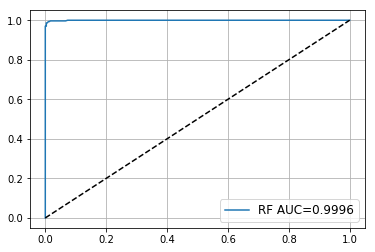

In [16]:
plot_roc_auc(y_val, y_pred, model_name='RF')